# Programming Final Project: Gradient

## CS445: Computational Photography - Spring 2020

### Proposal:
We propose to create a drawing animation algorithm to “draw” a still image provided by the user. Using gradient domains we will create a “line drawing” representation of the image, then create an algorithm that fills in these lines over the course of a short animation, as if an artist were drawing the image.

### Motivation:
This project will utilize techniques learned in the class, such as gradient domains, to build an animation that can be used as an aid for students learning to draw from still images, or as an effect that could be used in places like movie trailers. This is a feature that could be used in image/video software like Photoshop or After Effects.


In [30]:


# System imports
from os import path
import math
from random import sample 
from scipy.sparse import csr_matrix
from scipy.sparse import lil_matrix
import scipy.sparse.linalg as la
import statistics


# Third-Party Imports
import cv2
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

import warnings
warnings.filterwarnings('ignore')

import PIL
from PIL import Image, ImageDraw
import pprint
from scipy.interpolate import splprep, splev



def plot_img(images, titles):
    fig, axs = plt.subplots(nrows = 1, ncols = len(images),figsize=(10,10))
    if len(images) > 1:
        for i, p in enumerate(images):
            axs[i].imshow(p)
            if(titles):
                axs[i].set_title(titles[i])
            axs[i].axis('off')
    else:
            axs.imshow(images[0])
            if(titles):
                axs.set_title(titles[0])
            axs.axis('off')
    plt.show()
    
def plot_img_gray(images, titles):
    fig, axs = plt.subplots(nrows = 1, ncols = len(images),figsize=(10,10))
    if len(images) > 1:
        for i, p in enumerate(images):
            axs[i].imshow(p, cmap="gray")
            if(titles):
                axs[i].set_title(titles[i])
            axs[i].axis('off')
    else:
            axs.imshow(images[0], cmap="gray")
            if(titles):
                axs.set_title(titles[0])
            axs.axis('off')
    plt.show()
    

### Finding Gradient:


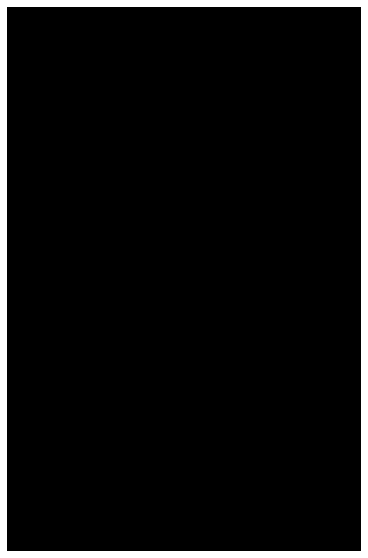

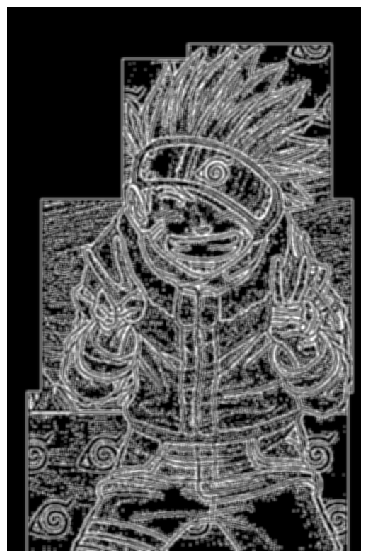

(768, 500)


In [37]:
"""
Created on Sat Apr 25 12:02:58 2020

@author: Tom Phelan and Will Wang
"""


def get_gradient(img):
    #gets the gradient image


    grad_img = cv2.Laplacian(img,cv2.CV_64F)
    grad_img = np.abs(grad_img)

    #plt.imshow(grad_img, cmap="gray")
    
    return grad_img

def get_edges(img):
    #gets the edges in binary
    
    grad_img = cv2.Canny(img,100,200)

    #grad_img[grad_img == 255] = 1
    #grad_img[grad_img == 0] = 255
    #grad_img[grad_img == 1] = 0
    
    return grad_img

def Sorting(lst): 
    lst2 = sorted(lst, key=len, reverse = True) 
    return lst2 
      

def gradient_prioritize(grad_img, edge_img):
    
    #for now, just labeling each pixel sequentially. Add better criteria later.
    #look into the Canny edge detector algorithm for blob/length detection
    h, w = edge_img.shape
    
    #s = 0
    
    priority = []
    '''
    #basic top to bottom order
    for i in range(h):
        for j in range(w):
            if edge_img[i,j] == 0:
                priority.append((i,j))
                #s += 1
    '''
    #code for using basic results of contours 
    #Next steps include developing a priority weight based on length of line,
    #proximity to center, strength of gradient, and other factors.
    
    contours, hierarchy = cv2.findContours(edge_img,cv2.RETR_LIST, cv2.CHAIN_APPROX_SIMPLE)
    
#     print(image)
#     print(hierarchy)
#     pp = pprint.PrettyPrinter(indent=4)
#     pp.pprint(lines.shape)
    

#     for i in lines[1]:
#         for j in i:
#             coord = tuple(map(tuple, j))
#             priority.append(coord[0])
#                 s += 1       

    contours = Sorting(contours)
    
    priority = []
    filter_contours = []
    c_len = []
    average_length = sum(map(len, contours))/float(len(contours))
    print(map(len, contours))
    img = np.zeros([h, w, 3])

    
    for i in range(len(contours)):
        cnt = contours[i]
        c_len.append(len(contours[i]))
        if (len(cnt) > average_length ):
            filter_contours.append(cnt)
            img = cv2.drawContours(img, [cnt], 0, (0,255,0), 3)
            draw_img = cv2.cvtColor(np.rint(img).astype(np.uint8), cv2.COLOR_RGB2GRAY)
            priority.append(draw_img/255)

#     for i in range(math.ceil(len(priority)/5) ):
#         plot_img_gray(priority[0+i*5:i*5+5],[])
        
#     plt.hist(c_len, bins=100)
#     plt.show()
    
    (thresh, binRed) = cv2.threshold(grad_img, 50, 255, cv2.THRESH_BINARY)
    
    r_areas = [cv2.contourArea(c) for c in contours]
    max_rarea = np.max(r_areas)
    CntExternalMask = np.ones(binRed.shape[:2], dtype="uint8") * 255

    for c in contours:
        if(( cv2.contourArea(c) > max_rarea * 0.70) and (cv2.contourArea(c)< max_rarea)):
            cv2.drawContours(CntExternalMask,[c],-1,0,1)

    plot_img_gray([CntExternalMask],[])
    
        
    priority_pixel = []
    for i in range(len(filter_contours)):
        for j in range(len(filter_contours[i])):
            priority_pixel.append(filter_contours[i][j][0])
            
    #lines, line_h = cv.findContours(edge_img, cv.RETR_TREE, cv.CHAIN_APPROX_SIMPLE)
    
    return priority_pixel




def DoG(img):
    high_sigma = cv2.GaussianBlur(img,(3,3),0)
    low_sigma = cv2.GaussianBlur(img,(5,5),0)
    
    images = low_sigma - high_sigma
    return images


def filter_pixel(priority_pixel,img):
    kernel = np.ones((5,5),np.float32)/25
    dst = cv2.filter2D(DoG(DoG(img)),-1,kernel)
    plot_img_gray([dst],[])

    f_priority_pixel = []
    
    print(img.shape)
    
#     plt.hist(dst, bins=100)
#     plt.show()
    
    for i in range(len(priority_pixel)):
        x,y = priority_pixel[i]
        if(dst[y,x] > 30):
            f_priority_pixel.append(priority_pixel[i])
            
    return f_priority_pixel




def sketch_to_original(draw_img, img):
    #creates a series of images merging between gradient image and original
    draw_img = draw_img.astype(float)
    nf = 60
    img_diff = (img - draw_img)
    img_diff /= nf
    h, w = draw_img.shape
    
    output_series = []
    
    for i in range(nf):
        draw_img += img_diff
        output_series.append(Image.fromarray(cv2.cvtColor(np.rint(draw_img).astype(np.uint8), cv2.COLOR_GRAY2RGB)))

    return output_series        
    

def gif_creator(img, speed, filepath):
    #creates gif of sketching, with pixes added at rate of speed parameter
    
    grad_img = get_gradient(img)
    edge_img = get_edges(img)
    priority = gradient_prioritize(grad_img, edge_img)
#     priority = filter_pixel(priority,img)
    
    sketch_img = np.zeros(grad_img.shape).astype(np.uint8)
    sketch_img += 255
    
    h, w = grad_img.shape
    pix = 0

    frames = math.ceil(len(priority)/speed)
    
    output_series = []
    
    for i in range(frames):
        for j in range(speed):
            x, y = priority[pix]
            sketch_img[y, x] = img[y, x]
            pix += 1
        output_series.append(Image.fromarray(cv2.cvtColor(sketch_img, cv2.COLOR_GRAY2RGB)))

        #adjusting last frame so it will finish the remaining pixels
        if i == frames - 2:
            speed = len(priority) - pix - 1
    
    end_merge = sketch_to_original(sketch_img, img)
    
    output_series += end_merge
    
    output_series[0].save(filepath, save_all = True,
                          append_images = output_series[1:], duration = 40)
    
            
al_img = cv2.cvtColor(cv2.imread('images/naroto.png'), cv2.COLOR_BGR2RGB)
al_img = cv2.cvtColor(al_img, cv2.COLOR_BGR2GRAY)
#plt.imshow(al_img, cmap="gray")
filepath = 'output/al_sketch.gif'
gif_creator(al_img, 20, filepath)


    

In [28]:

from IPython.display import HTML
HTML('<img src="output/al_sketch.gif">')

In [ ]:
alfred = cv2.imread("./images/naroto.png")

# alfred = alfred_file.astype("double") / 255

plot_img_gray([alfred],["alfred"])




def get_gradient(img):
    #gets the gradient image
    image = []
    sigma = 0.25
    blur = img
    
#     blur = cv2.GaussianBlur(grad_img, (3, 3), 0)

    for i in range(5):
        v = np.median(blur)
        # apply automatic Canny edge detection using the computed median
        lower = int(max(0, (1.0 - sigma) * v))
        upper = int(min(255, (1.0 + sigma) * v))
        blur = cv2.Canny(blur,lower,upper)
        image.append(blur)
        plt.imshow(blur, cmap="gray")
    return image

def DoG(img):
    
    high_sigma = cv2.GaussianBlur(img,(3,3),0)
    low_sigma = cv2.GaussianBlur(img,(5,5),0)
    
    images = low_sigma - high_sigma
    return images

images = get_gradient(alfred)

plot_img_gray(images,[])

plot_img_gray([DoG(DoG(alfred))],[])

kernel = np.ones((5,5),np.float32)/25
dst = cv2.filter2D(DoG(DoG(alfred)),-1,kernel)

plot_img_gray([dst],[])

print(np.min(images[0]))
